In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("error")

In [2]:
from estimator import NNSingleFunctionalEstimator
from formula import SingleDensityFunctionalFormulasUniform, SingleDensityFunctionalFormulasGaussian
from utility import draw_truncated_gaussians

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
params = {
    'axes.labelsize': 10,
    'font.family': "serif",  
    'font.serif': "Palatino",
    'legend.fontsize': 10,
    'lines.markersize': 5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    'figure.figsize': [4.5, 4.5]
   }
matplotlib.rcParams.update(params)

In [5]:
markers = ['o', 's', '*', 'v', '^', 'D', 'h', 'x', '+', '8', 'p', '<', '>', 'd', 'H', 1, 2, 3, 4]

In [6]:
colormap = plt.cm.Paired  # print(matplotlib.cm.cmap_d.keys()) to check available color maps
colors = [colormap(i) for i in np.linspace(0, 1, 12)]

# (1) Single-density case

## Configurations

In [7]:
# Main configuration
dims = [1, 2, 3, 4, 5]
ms = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]  # sample sizes
num_trials = 500

In [8]:
# Compute estimates
alphas = [0.5, 1.5, 2, 2.5]
ks = np.array([1, 2, 3, 4, 5] + [10, 15, 20])
beta = 1

alphas_str = ','.join([str(alpha) for alpha in alphas])
knn_estimator = NNSingleFunctionalEstimator(ks, alphas=alphas, beta=beta)

In [9]:
distribution_type = 'gaussians'
distribution_type = 'uniforms'
assert distribution_type in ['gaussians', 'uniforms']

if distribution_type == 'gaussians':
    # Hyperparameters for gaussians
    r = np.inf
    sampler_single = lambda m, d: draw_truncated_gaussians(m, d, r=r)  # draw Gaussians; (m, d) matrix    
    true_functional_values = SingleDensityFunctionalFormulasGaussian(r=r, dims=dims).functionals(alphas, beta)
    
if distribution_type == 'uniforms':
    # Hyperparameters for uniforms
    r = 1
    sampler_single = lambda m, d: r * np.random.rand(m, d)  # draw Uniforms; (m, d) matrix
    true_functional_values = SingleDensityFunctionalFormulasUniform(r=r, dims=dims).functionals(alphas, beta)

filename = 'single_estimates_alphas{}beta{}_{}_r{}_ntrials{}.npz'.format(
    alphas_str, beta, distribution_type, r, str(num_trials)
)

true_functional_values = true_functional_values[..., np.newaxis, np.newaxis]  # (num_functionals, ndims, 1, 1)

## Run experiments or load data

In [10]:
if os.path.exists(filename):
    npzfile = np.load(filename, allow_pickle=True)
    locals().update(npzfile)
else:
    start_overall = time.time()
    functional_estimates = np.zeros((knn_estimator.num_functionals, len(dims), len(ms), len(ks), num_trials))
    for idim in range(len(dims)):
        for im in range(len(ms)):
            # for each dimension and each sample size
            d = dims[idim]
            m = ms[im]
            start = time.time()
            for itrial in range(num_trials):
                x = sampler_single(m, d)
                estimates = knn_estimator.estimate(x)  # (num_functionals, k) matrix
                functional_estimates[:, idim, im, :, itrial] = estimates;
            end = time.time()
            print('dim={}, m={}; {:.2f}s elapsed'.format(d, m, end-start))
    end_overall = time.time()
    print('Total {:.2f}s elapsed'.format(d, m, end_overall - start_overall))
    
    # Save functional estimates
    data = dict(ms=ms, 
                dims=dims, 
                ks=ks, 
                functional_estimates=functional_estimates, 
                r=r,
                distribution_type=distribution_type)
    np.savez(filename, **data)
    

# Compute sample means, biases, variances, and mses
sample_means = functional_estimates.mean(-1)  # mean over trials; (num_functionals, ndims, nms, nks)
biases = np.abs(sample_means - true_functional_values)  # (num_functionals, ndims, nms, nks)
variances = ((functional_estimates - sample_means[..., np.newaxis])**2).mean(-1)  # (num_functionals, ndims, nms, nks)
mses = biases ** 2 + variances

## Plot convergence

1-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

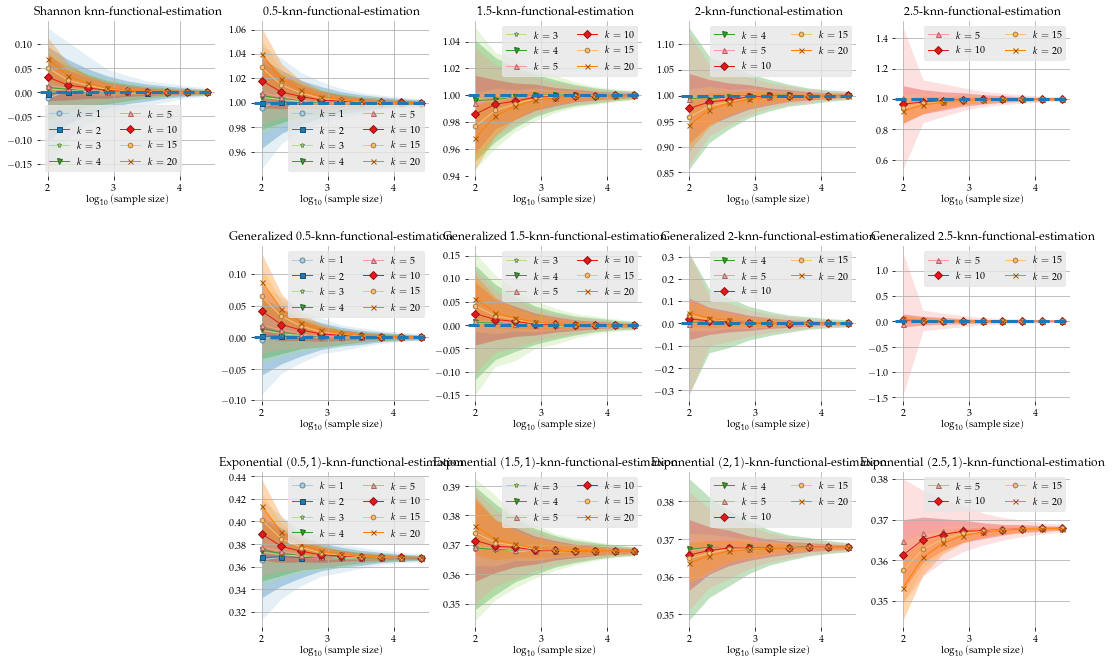

2-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

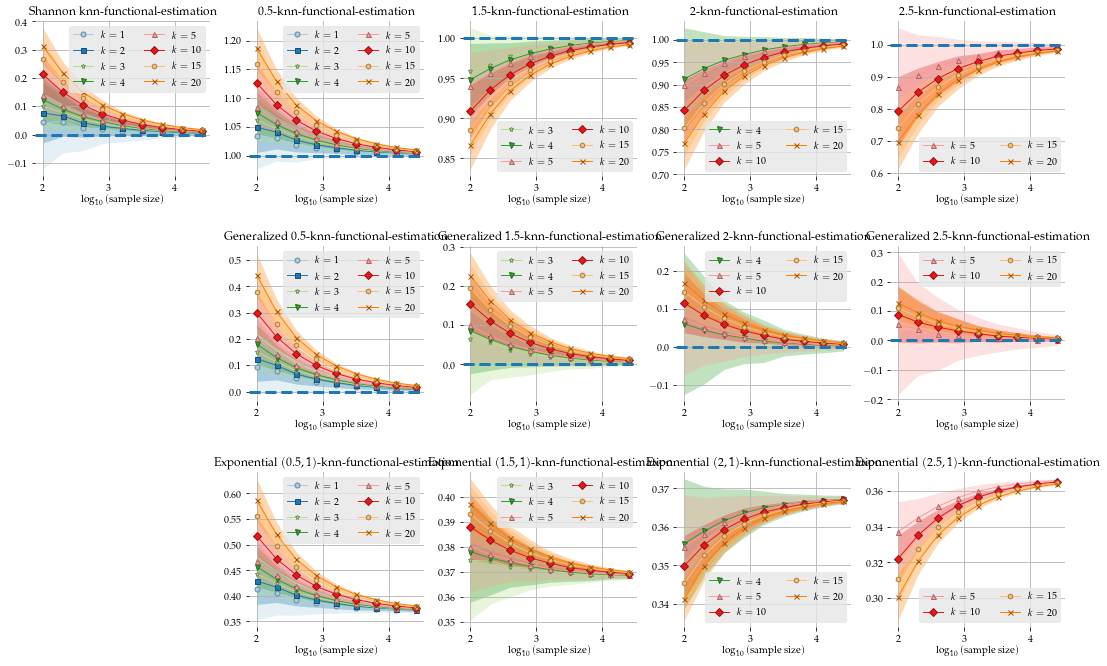

3-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

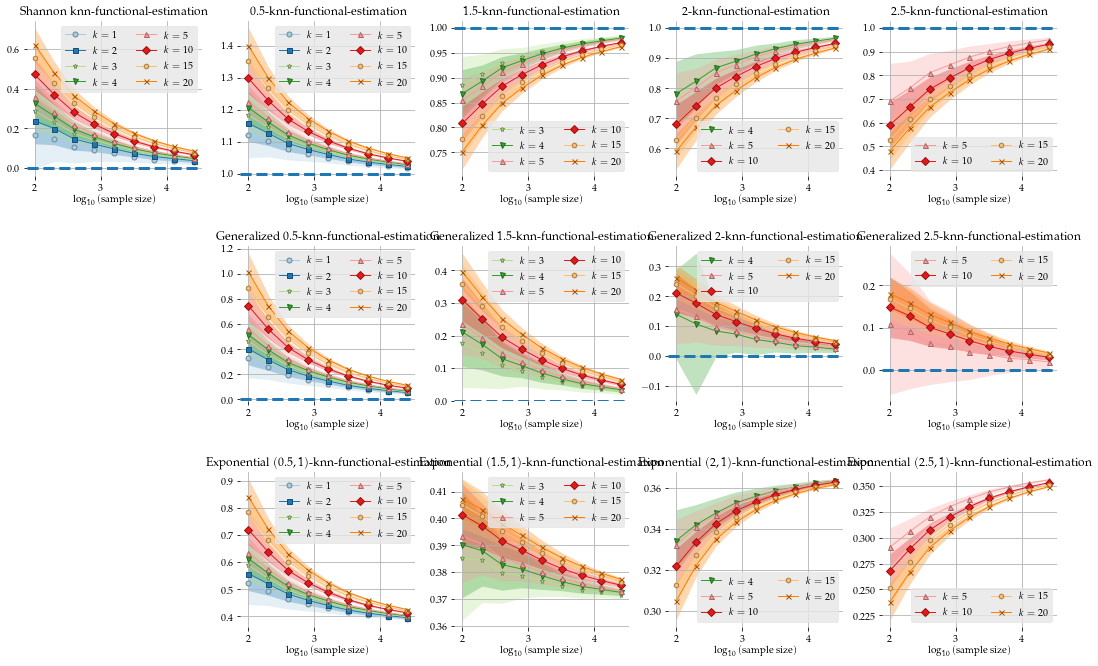

4-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

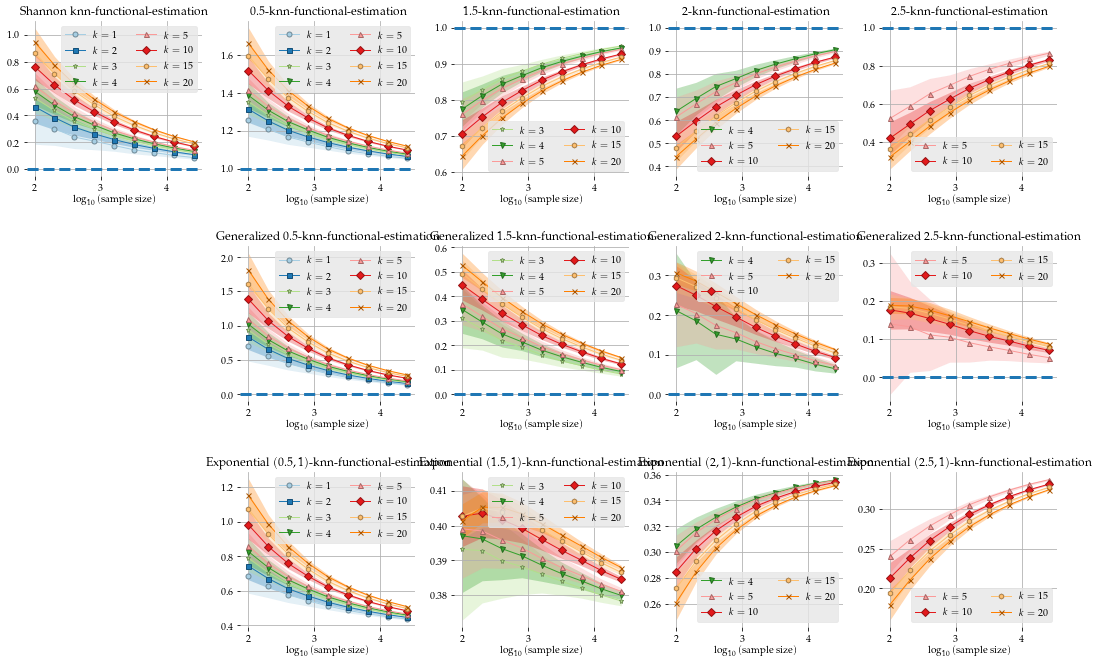

5-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

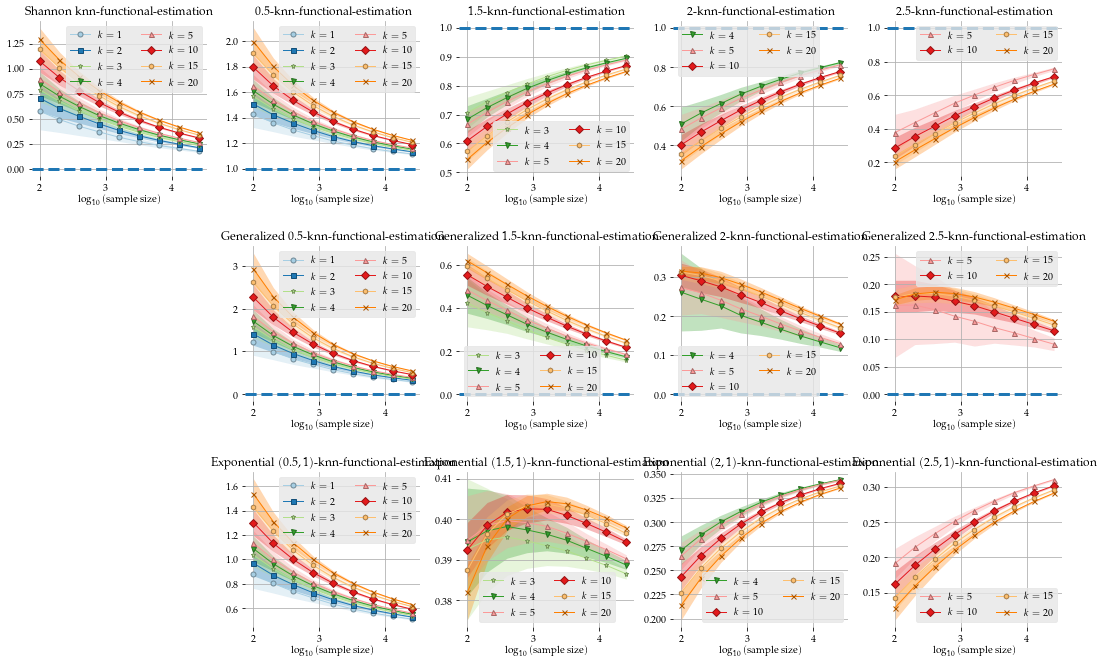

In [11]:
# Plot actual convergence with sample variance
for idim in range(len(dims)):
    print('{}-dim {} ($r={}$)'.format(
        dims[idim],
        distribution_type,
        r,
    ))
    plt.figure(idim, clear=True)
    fig, axs = plt.subplots(3, len(alphas) + 1, figsize=(15, 9))
    fig.tight_layout(h_pad=5)
    
    for i in range(3):
        for j in range(len(alphas) + 1):
            ax = axs[i][j]
            ax.spines["top"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
        
    # differential entropy
    iftn = 0
    ax = axs[0][0]
    ax.grid()
    for ik in range(len(ks)):
        ax.plot(np.log10(ms), sample_means[iftn, idim, :, ik], 
                '{}-'.format(markers[ik]), 
                color=colors[ik],
                linewidth=1,
                markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                label='$k={}$'.format(ks[ik]))
        ax.fill_between(np.log10(ms), 
                (sample_means-np.sqrt(variances))[iftn, idim, :, ik], 
                (sample_means+np.sqrt(variances))[iftn, idim, :, ik],
                color=colors[ik],
                linewidth=0.1, 
                alpha=0.3)
    ax.axhline(true_functional_values[iftn, idim, 0, 0], linestyle='--', linewidth=3)
    
    legend = ax.legend(ncol=2)
    frame = legend.get_frame()
    frame.set_facecolor('0.9')
    frame.set_edgecolor('0.9')
    
    ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
    ax.set_title(knn_estimator.functional_names[iftn])
    
    # Put empty plot
    ax = axs[1][0]
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[2][0]
    ax.set_xticks([])
    ax.set_yticks([])
    
    # alpha entropy and generalized alpha entropy
    for iftn in range(1, knn_estimator.num_functionals):
        i = (iftn-1) // len(alphas)  # i=0: alpha entropy / i=1: generalized alpha entropy
        j = (iftn-1) % len(alphas)
        alpha = alphas[j]
        
        ax = axs[i][j+1]
        ax.grid()
        for ik in range(len(ks)):
            if ks[ik] > 2 * (alpha - 1):
                ax.plot(np.log10(ms), sample_means[iftn, idim, :, ik], 
                        '{}-'.format(markers[ik]), 
                        color=colors[ik],
                        linewidth=1,
                        markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                        label='$k={}$'.format(ks[ik]))
                ax.fill_between(np.log10(ms), 
                        (sample_means-np.sqrt(variances))[iftn, idim, :, ik], 
                        (sample_means+np.sqrt(variances))[iftn, idim, :, ik],
                        color=colors[ik],
                        linewidth=0.1, 
                        alpha=0.3)
        if iftn < knn_estimator.num_functionals - len(alphas):
            ax.axhline(true_functional_values[iftn, idim, 0, 0], linestyle='--', linewidth=3)
        
        legend = ax.legend(ncol=2)
        frame = legend.get_frame()
        frame.set_facecolor('0.9')
        frame.set_edgecolor('0.9')
        
        ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
        ax.set_title(knn_estimator.functional_names[iftn])
    plt.savefig('single_{}_r{}_d{}_convergence.pdf'.format(distribution_type, r, dims[idim]))
    plt.show()

1-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

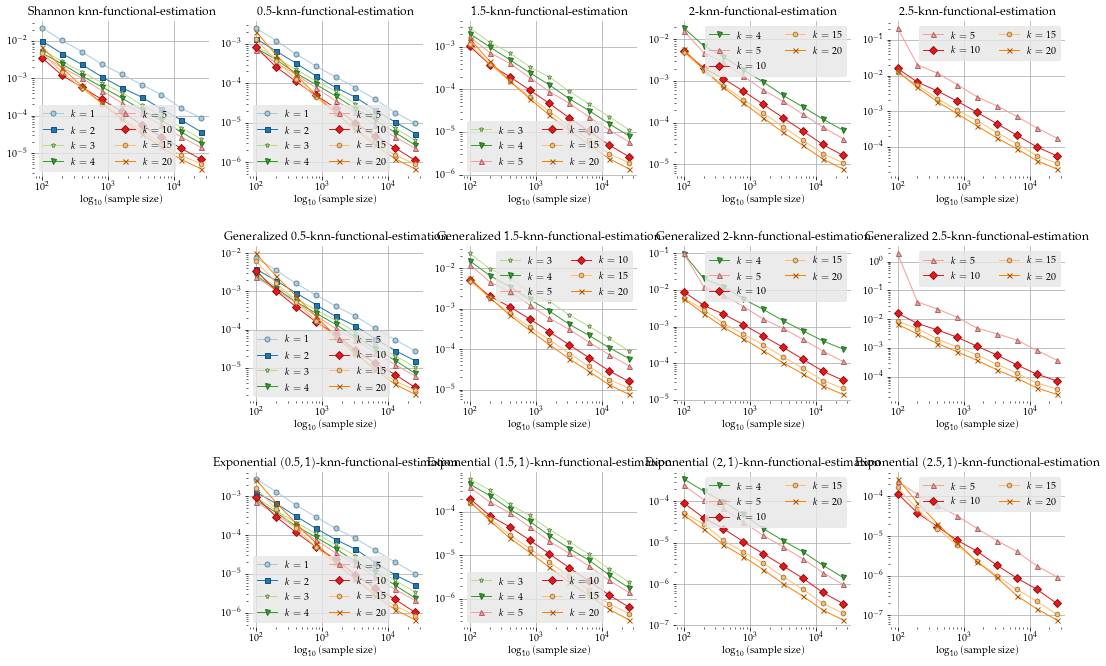

2-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

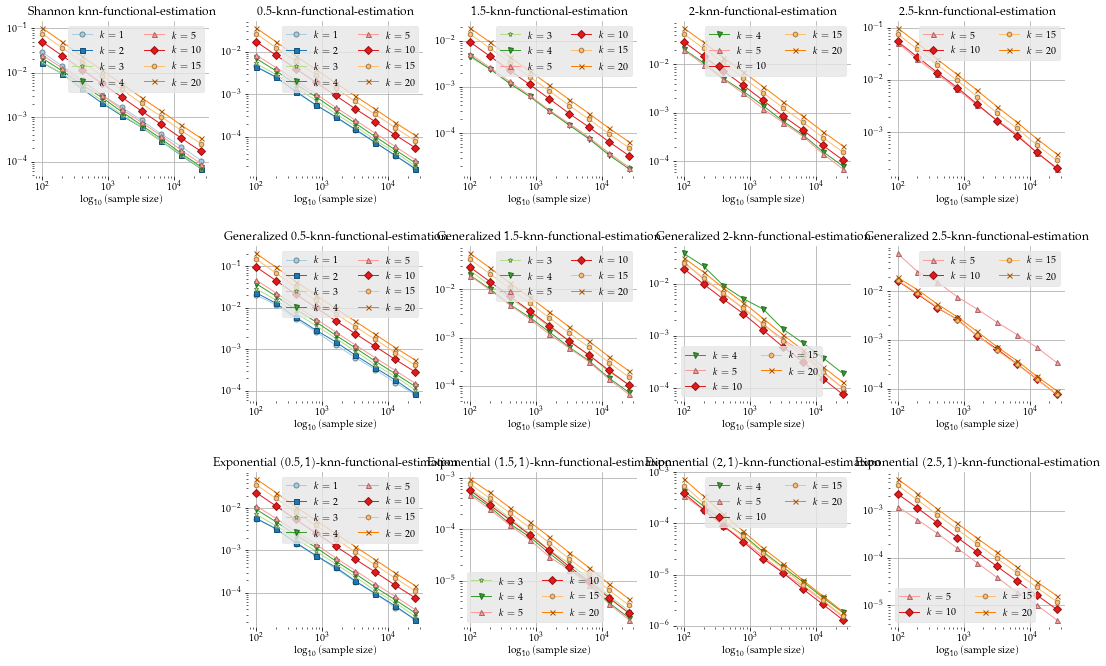

3-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

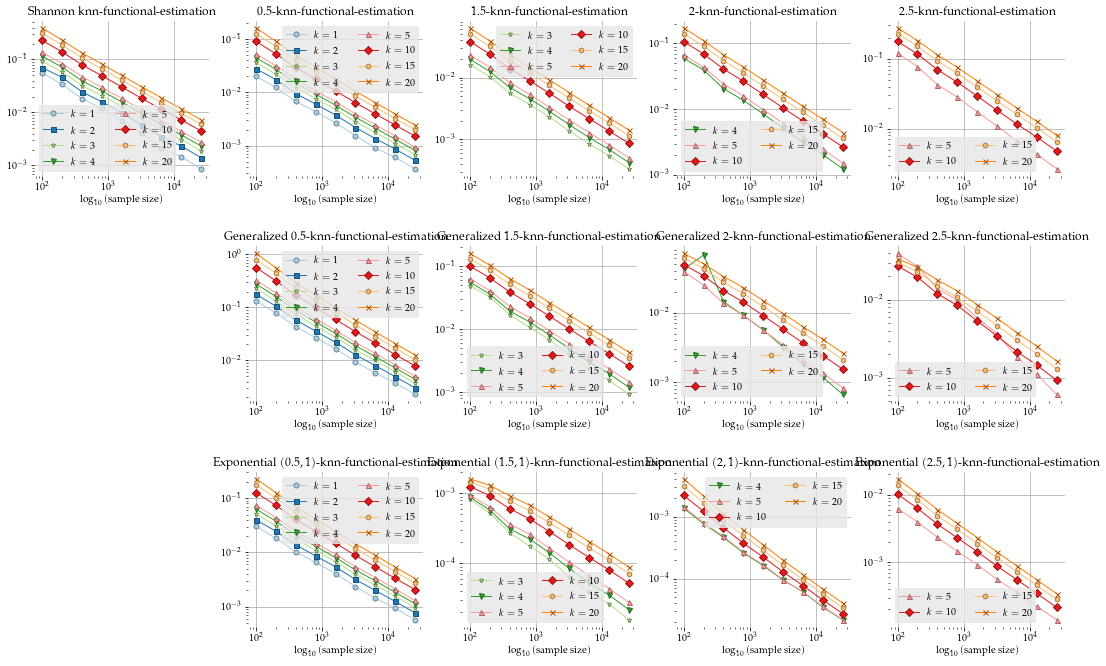

4-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

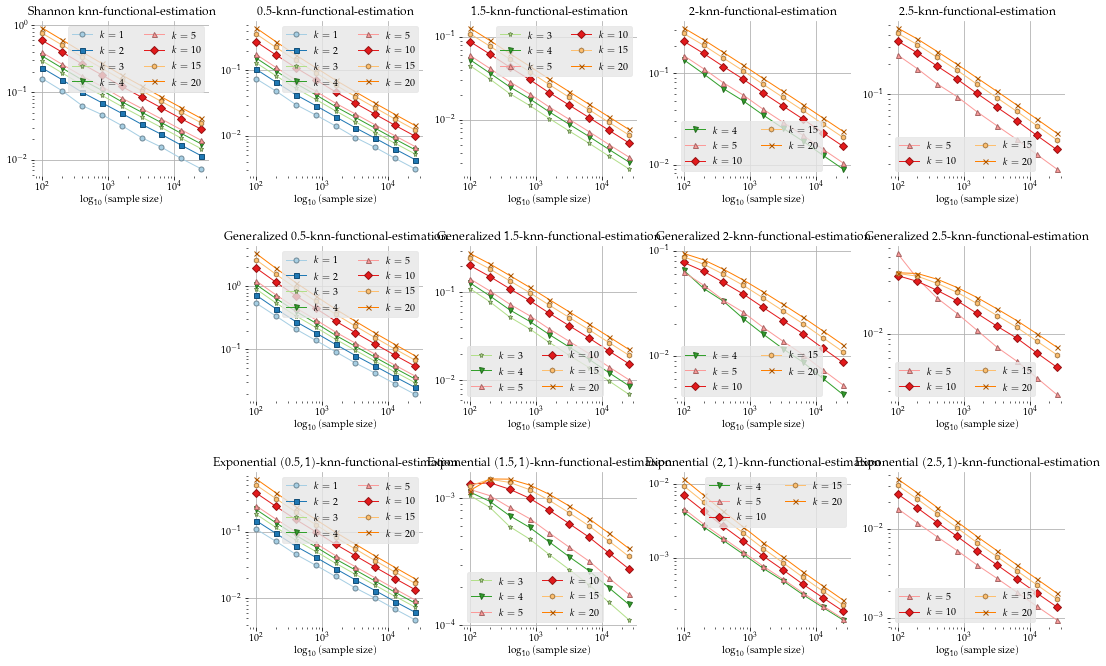

5-dim uniforms ($r=1$)


<Figure size 324x324 with 0 Axes>

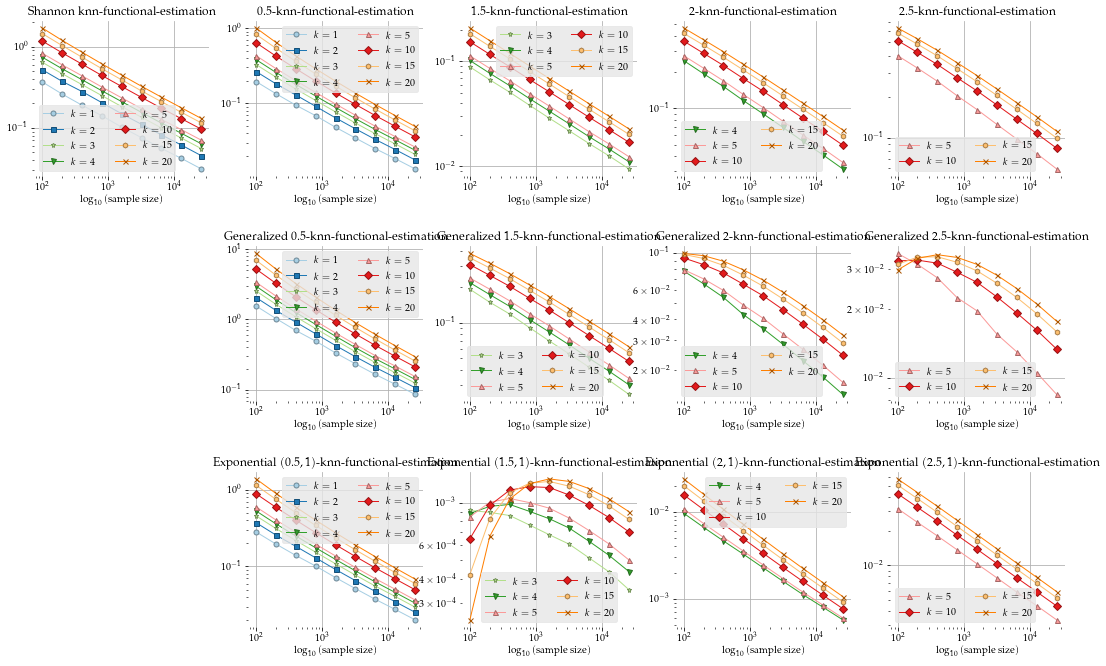

In [12]:
# Plot log(m) vs. log(MSE) for sanity check
for idim in range(len(dims)):
    print('{}-dim {} ($r={}$)'.format(
        dims[idim],
        distribution_type,
        r,
    ))
    plt.figure(idim, clear=True)
    fig, axs = plt.subplots(3, len(alphas) + 1, figsize=(15, 9))
    fig.tight_layout(h_pad=5)
    
    for i in range(3):
        for j in range(len(alphas) + 1):
            ax = axs[i][j]
            ax.spines["top"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
        
    # differential entropy
    iftn = 0
    ax = axs[0][0]
    ax.grid()
    for ik in range(len(ks)):
        ax.loglog(ms, mses[iftn, idim, :, ik], 
                  '{}-'.format(markers[ik]), 
                  color=colors[ik],
                  linewidth=1,
                  markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                  label='$k={}$'.format(ks[ik]))
    
    legend = ax.legend(ncol=2)
    frame = legend.get_frame()
    frame.set_facecolor('0.9')
    frame.set_edgecolor('0.9')
    
    ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
    ax.set_title(knn_estimator.functional_names[iftn])
    
    # Put empty plots
    ax = axs[1][0]
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[2][0]
    ax.set_xticks([])
    ax.set_yticks([])
    
    # alpha entropy and generalized alpha entropy
    for iftn in range(1, knn_estimator.num_functionals):
        i = (iftn-1) // len(alphas)  # i=0: alpha entropy / i=1: generalized alpha entropy
        j = (iftn-1) % len(alphas)
        alpha = alphas[j]
        
        ax = axs[i][j+1]
        ax.grid()
        for ik in range(len(ks)):
            if ks[ik] > 2 * (alpha - 1):
                ax.loglog(ms, mses[iftn, idim, :, ik], 
                          '{}-'.format(markers[ik]), 
                          color=colors[ik],
                          linewidth=1,
                          markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                          label='$k={}$'.format(ks[ik]))
        
        legend = ax.legend(ncol=2)
        frame = legend.get_frame()
        frame.set_facecolor('0.9')
        frame.set_edgecolor('0.9')
        
        ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
        ax.set_title(knn_estimator.functional_names[iftn])
#     plt.savefig('single_{}_r{}_d{}_mse.pdf'.format(distribution_type, r, dims[idim]))
    plt.show()

## Plot MSE exponents

In [13]:
# Compute exponents
exponents = np.zeros((3, knn_estimator.num_functionals, len(dims), len(ks)));  # first axis = (MSE, bias, variance)
nwarmup = 5
for iftn in range(knn_estimator.num_functionals-4):
    for idim in range(len(dims)):
        x = np.log(ms[nwarmup:])[..., np.newaxis];
        y = np.stack([np.log(mses[iftn, idim, nwarmup:, :]),
                      np.log(biases[iftn, idim, nwarmup:, :]),
                      np.log(variances[iftn, idim, nwarmup:, :] + 1e-5)], 0);

        # Perform ordinary linear regression to extract the slope
        cov = np.mean(x * y, 1) - np.mean(x) * np.mean(y, 1);
        var = np.mean((x - np.mean(x))**2);
        slope = cov / var;
        exponents[:, iftn, idim, :] = -np.squeeze(slope);

In [14]:
bias_exponents_theory = np.array([1/dim for dim in dims])
variance_exponents_theory = np.array([1 for dim in dims])
mse_exponents_theory = np.minimum(2 * bias_exponents_theory, variance_exponents_theory)
exponents_theory = np.stack([mse_exponents_theory,
                             bias_exponents_theory,
                             variance_exponents_theory], 0)

uniforms ($r=1$)


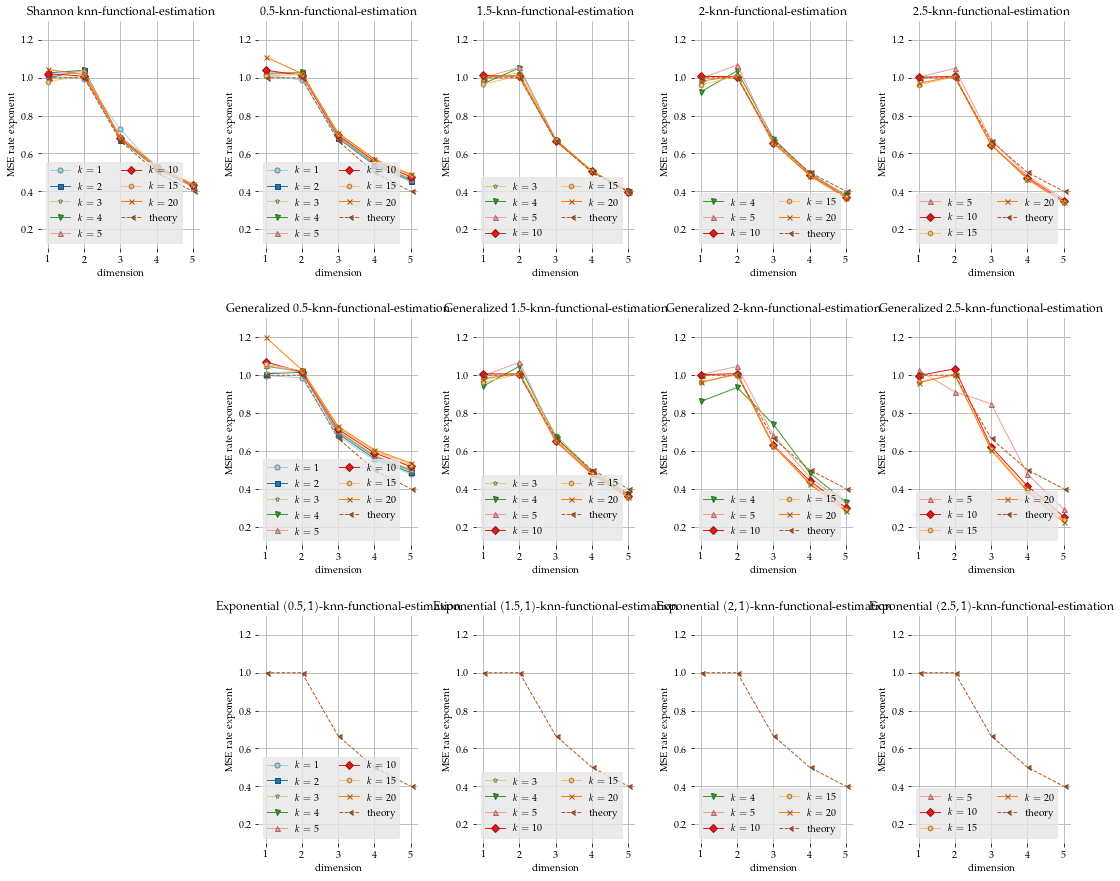

In [15]:
# Plot MSE exponents
fig, axs = plt.subplots(3, len(alphas) + 1, figsize=(15, 12))
fig.tight_layout(w_pad=3, h_pad=5)
ylim = [0.1, 1.3]

for i in range(3):
    for j in range(len(alphas) + 1):
        ax = axs[i][j]
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

# differential entropy
iftn = 0
ax = axs[0][0]
ax.grid()
for ik in range(len(ks)):
    ax.plot(dims, exponents[0, iftn, :, ik], '{}-'.format(markers[ik]),
            linewidth=1,
            label='$k={}$'.format(ks[ik]),
            markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
            color=colors[ik])

ax.plot(dims, exponents_theory[0, :],
        linewidth=1,
        marker=markers[-1],
        label='theory',
        linestyle='--',
        markeredgecolor=np.minimum(np.array(colors[-1][0:3])/1.5, 1),
        color=colors[-1])

legend = ax.legend(ncol=2, loc=3)
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')

ax.set_title(knn_estimator.functional_names[iftn])
ax.set_xlabel('dimension')
ax.set_ylabel('MSE rate exponent')
ax.set_ylim(ylim)

# Put empty plot
ax = axs[1][0]
ax.set_xticks([])
ax.set_yticks([])
ax = axs[2][0]
ax.set_xticks([])
ax.set_yticks([])

# alpha entropy and generalized alpha entropy
for iftn in range(1, knn_estimator.num_functionals):
    i = (iftn-1) // len(alphas)  # i=0: alpha entropy / i=1: generalized alpha entropy
    j = (iftn-1) % len(alphas)
    alpha = alphas[j]

    ax = axs[i][j+1]
    ax.grid()
    for ik in range(len(ks)):
        if iftn == 0 or ks[ik] > 2 * (alpha - 1):
            ax.plot(dims, exponents[0, iftn, :, ik], '{}-'.format(markers[ik]),
                    linewidth=1,
                    label='$k={}$'.format(ks[ik]),
                    markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                    color=colors[ik])
    
    ax.plot(dims, exponents_theory[0, :],
            linewidth=1,
            marker=markers[-1],
            label='theory',
            linestyle='--',
            markeredgecolor=np.minimum(np.array(colors[-1][0:3])/1.5, 1),
            color=colors[-1])
    
    legend = ax.legend(ncol=2, loc=3)
    frame = legend.get_frame()
    frame.set_facecolor('0.9')
    frame.set_edgecolor('0.9')

    ax.set_title(knn_estimator.functional_names[iftn])
    ax.set_xlabel('dimension');
    ax.set_ylabel('MSE rate exponent')
    ax.set_ylim(ylim)
    
print('{} ($r={}$)'.format(distribution_type, r))
plt.savefig('single_{}_r{}_exponents.pdf'.format(distribution_type, r))
plt.show()